In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import math
import pandas as pd
from dotenv import load_dotenv
import numpy as np

import statsmodels.api as sm

from tqdm import tqdm
from pathlib import Path

from concurrent.futures import ThreadPoolExecutor
from tqdm import trange, tqdm
import numpy as np
import pandas as pd

import seaborn as sns

import sys

current_path = sys.path[0]
sys.path.append(current_path[: current_path.find("defi-measurement")] + "liquidity-distribution-history")

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

In [4]:
# Set pandas display options column width
pd.set_option("display.max_colwidth", 1000)

In [5]:
postgres_uri = os.environ["POSTGRESQL_URI"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

plot_base_path = Path(
    "/Users/larsankile/Dropbox/Apps/Overleaf/Robust Detection of Extractive Attacks in Decentralized Exchanges/Figures"
)

save_plots = False

## Get data


In [6]:
count: int = int(
    pd.read_sql_query(
        """
    SELECT
        COUNT(*) as cnt
    FROM
        block_pool_metrics
    """,
        postgres_uri,
        dtype={"cnt": int},
    )
    .iloc[0]
    .cnt
)

f"Total number of rows: {count:,}"

'Total number of rows: 6,864,029'

In [7]:
if "df" in locals() and locals()["df"].shape[0] == count:
    print("Dataframe already loaded")
else:
    chunksize = 10_000

    dfs = pd.read_sql_query(
        """
        SELECT
            *
        FROM
            block_pool_metrics
        """,
        postgres_uri,
        chunksize=chunksize,
    )

    df = pd.concat(tqdm(dfs, total=math.ceil(count / chunksize)))

100%|██████████| 687/687 [01:46<00:00,  6.44it/s]


In [8]:
df.head()

,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,created_at,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,tstar_l1,tstar_l2,tstar_linf
0,15569292,0x0002e63328169d7feea121f1e32e4f620abf0352,1,0,1,0.326732,2023-08-23 19:47:19.321803,True,0.066007,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,0.014645,0.014645,0.014645
1,15577763,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.329891,2023-08-23 19:47:19.361765,True,0.104729,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,0.011220,0.011220,0.011220
2,15592175,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.341082,2023-08-23 19:47:19.407144,True,0.212331,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,0.011003,0.011003,0.011003
3,15813213,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352052,2023-08-23 19:47:19.443550,True,0.071058,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,0.016302,0.016302,0.016302
4,15935551,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352343,2023-08-23 19:47:19.490107,True,0.120780,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,0.057471,0.057471,0.057471


## Descriptive statistics


### Number of swaps in each pool-block pair


In [9]:
count_df = df.groupby("num_transactions").block_number.count().sort_index()
count_df = count_df[count_df.index < 50]
counts: np.ndarray = count_df.to_numpy()
index = count_df.index.to_numpy()

print(counts)
print(index)

[6075363  571623  151766   39511   13384    5663    2640    1366     849
     531     381     249     156     120     105      71      54      24
      30      21      20      11       4      11       8       5       5
       4       8       8       4       7       4       3       2       1
       4       1       1       1       1       2       1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 42 43 44 47]


Text(0.5, 1.0, 'Distribution of number of\ntransactions in (pool, block) pairs (log scale)')

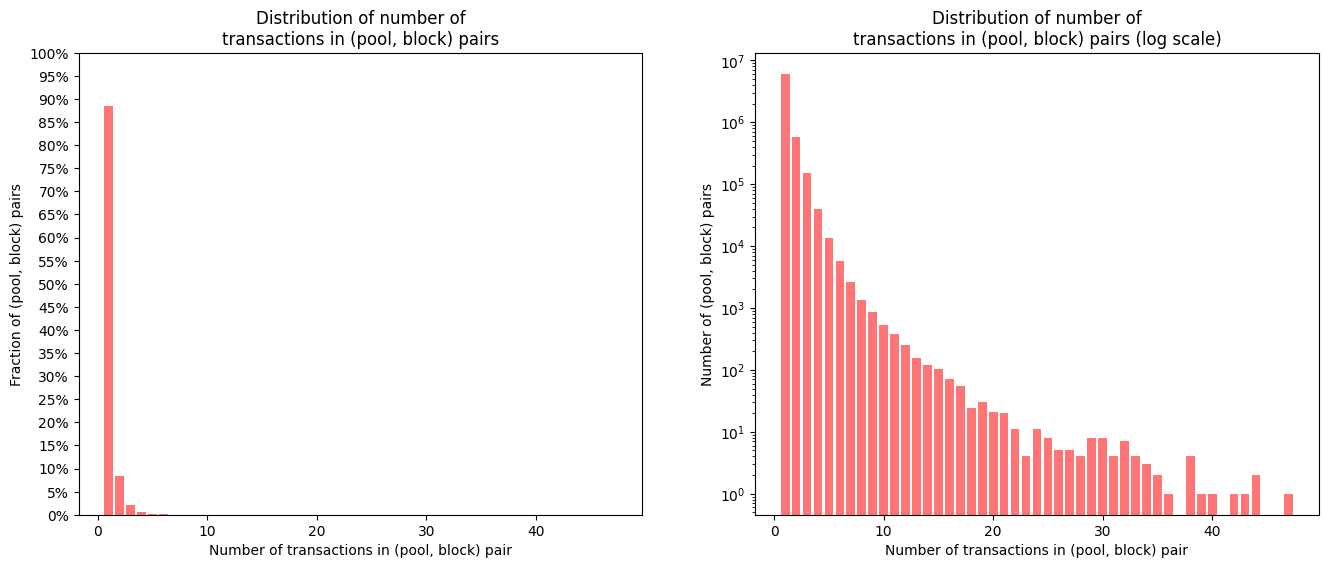

In [10]:
normalized = counts / counts.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_col = "#FF7474"

ax1.bar(index, normalized, color=bar_col)
ax1.set_xlabel("Number of transactions in (pool, block) pair")
ax1.set_ylabel("Fraction of (pool, block) pairs")
ax1.set_title("Distribution of number of\ntransactions in (pool, block) pairs")
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.set_yticks(np.arange(0, 1.05, 0.05))

ax2.bar(index, counts, color=bar_col)
ax2.set_yscale("log")
ax2.set_xlabel("Number of transactions in (pool, block) pair")
ax2.set_ylabel("Number of (pool, block) pairs")
ax2.set_title("Distribution of number of\ntransactions in (pool, block) pairs (log scale)")

### Number of blocks, min and max block number, total number of swaps, and total number of pools


In [11]:
print(f"There are {len(df)} (pool, block) pairs in the database")
print(f"There are {df.block_number.nunique():,} unique blocks in the database")
print(f"First block: {df.block_number.min():,}, last block: {df.block_number.max():,}")
print(f"Total number of transactions: {df.num_transactions.sum():,}")
print(f"There are {df.pool_address.nunique():,} unique pools in the database")

There are 6864029 (pool, block) pairs in the database
There are 1,866,537 unique blocks in the database
First block: 15,537,940, last block: 17,864,015
Total number of transactions: 7,994,736
There are 6,292 unique pools in the database


### Share of blocks, swaps, and pools created through MEV-boost auctions


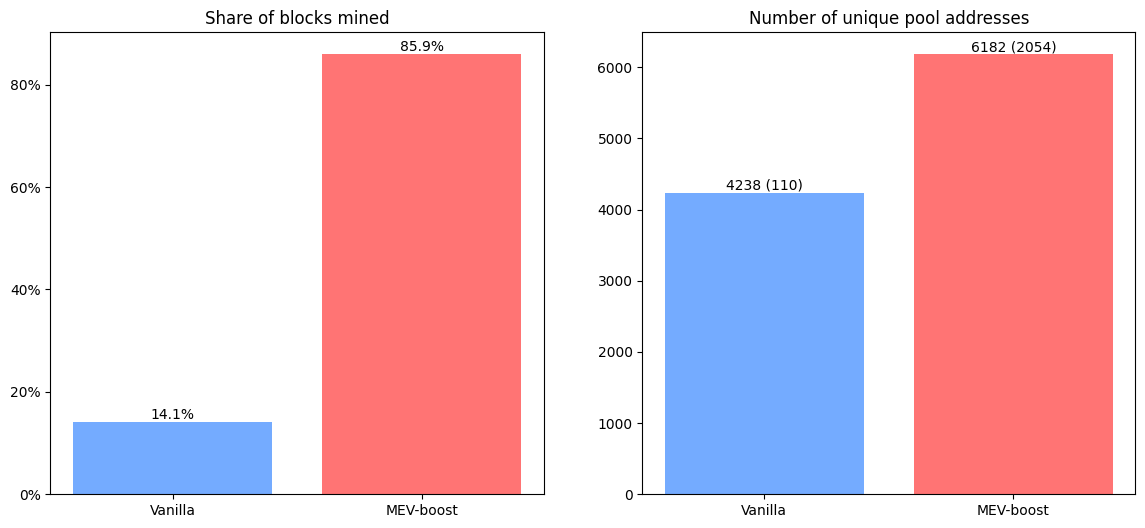

In [12]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bar_cols = ["#74ABFF", "#FF7474", "#F3DAFF"]

# First plot
block_share = df.groupby("mev_boost").block_number.nunique().sort_index()
bars = ax1.bar(["Vanilla", "MEV-boost"], block_share.values / block_share.sum(), color=bar_cols)
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax1.set_title("Share of blocks mined")

# Second plot
pool_count = df.groupby("mev_boost").pool_address.nunique().sort_index()
bars = ax2.bar(["Vanilla", "MEV-boost"], pool_count.values, color=bar_cols)

only_vanilla = set(df[df.mev_boost == False].pool_address.unique())
only_mev = set(df[df.mev_boost == True].pool_address.unique())
only_vanilla_count = len(only_vanilla - only_mev)
only_mev_count = len(only_mev - only_vanilla)

# Add the values atop the bars
for bar, only in zip(bars, [only_vanilla_count, only_mev_count]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f"{height} ({only})", ha="center", va="bottom")

ax2.set_title("Number of unique pool addresses")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "descriptive" / "blocks_mined.pdf"))

In [13]:
def get_p_value(sums, counts):
    # Assuming group1 and group2 are the two groups with binary values (0 or 1)
    count1 = sums.loc[False]
    count2 = sums.loc[True]
    n1 = counts.loc[False]
    n2 = counts.loc[True]

    _, p_value = sm.stats.proportions_ztest([count1, count2], [n1, n2])

    return p_value

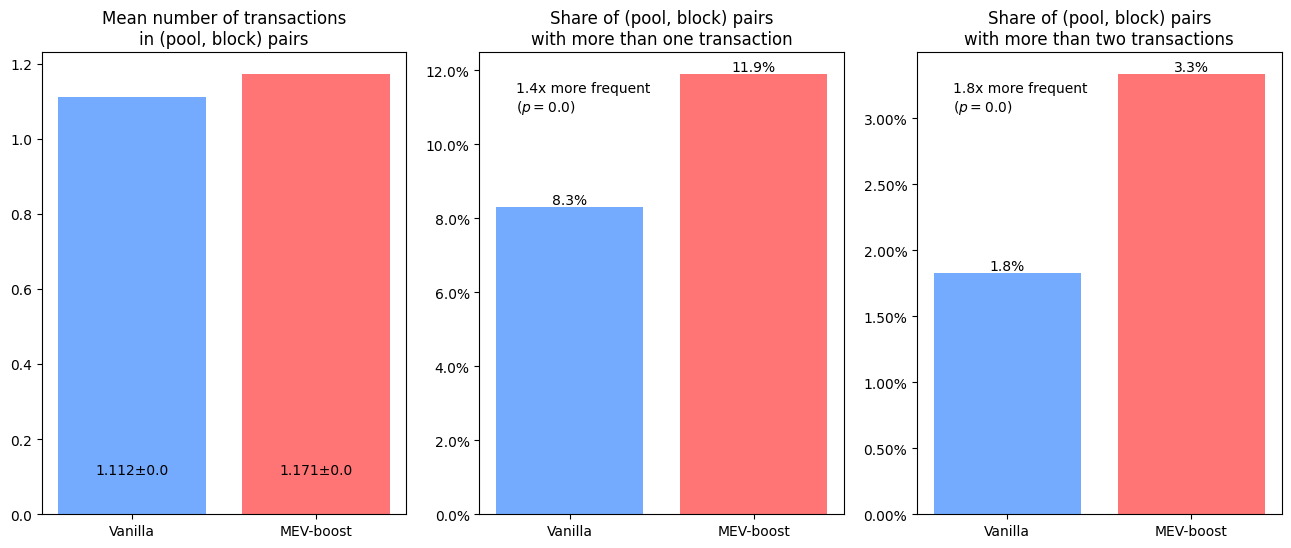

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# First plot
n_transaction_mean = df.groupby("mev_boost").num_transactions.mean().sort_index()
n_transaction_std = df.groupby("mev_boost").num_transactions.std().sort_index()
n_transaction_sem = df.groupby("mev_boost").num_transactions.sem().sort_index()

bars = ax1.bar(["Vanilla", "MEV-boost"], n_transaction_mean.values, color=bar_cols, yerr=n_transaction_sem.values)

# Add the values at the base of the bars
for bar, mean, std in zip(bars, n_transaction_mean.values, n_transaction_sem.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, 0.1, f"{mean:.3f}±{std:.1f}", ha="center", va="bottom")

ax1.set_title("Mean number of transactions\nin (pool, block) pairs")

# Second plot
share_more_than_one_mean = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.mean().sort_index()
)
sum_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.sum().sort_index()
)
count_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.count().sort_index()
)
p_value = get_p_value(sum_more_than_one, count_more_than_one)

bars = ax2.bar(["Vanilla", "MEV-boost"], share_more_than_one_mean.values, color=bar_cols)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax2.set_title("Share of (pool, block) pairs\nwith more than one transaction")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_one_mean.values[1] / share_more_than_one_mean.values[0]
ax2.text(
    0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha="left", va="center", transform=ax2.transAxes
)

# Third plot
share_more_than_two_mean = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.mean().sort_index()
)
sum_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.sum().sort_index()
)
count_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.count().sort_index()
)
p_value = get_p_value(sum_more_than_two, count_more_than_two)

bars = ax3.bar(["Vanilla", "MEV-boost"], share_more_than_two_mean.values, color=bar_cols)
ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax3.set_title("Share of (pool, block) pairs\nwith more than two transactions")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_two_mean.values[1] / share_more_than_two_mean.values[0]
ax3.text(
    0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha="left", va="center", transform=ax3.transAxes
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "descriptive" / "transactions_per_block.pdf"))

In [15]:
from scipy.stats import ttest_ind

# Split the data into two groups based on MEV-boost (true/false)
group1 = df[df["mev_boost"] == True]["num_transactions"]
group2 = df[df["mev_boost"] == False]["num_transactions"]

# Perform the two-sample t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:3e}")

T-statistic: 86.515
P-value: 0.000000e+00


## Statistics on the Metric


In [16]:
df_metric = df.assign(
    metric_l1=df.realized_l1 / df.volume_heur_l1 - 1,
    metric_l2=df.realized_l2 / df.volume_heur_l2 - 1,
    metric_linf=df.realized_linf / df.volume_heur_linf - 1,
)


# Take out extreme outliers
outlier_thresh = 1e1
cnt_before = len(df_metric)
df_metric = df_metric[(df_metric.metric_l1 < outlier_thresh) & ((df_metric.metric_l1 >= 0))]
cnt_after = len(df_metric)
print(f"Removed {cnt_before - cnt_after} outliers ({(cnt_before - cnt_after) / cnt_before:.3%})")

df_metric_1 = df_metric[df_metric.num_transactions > 1]
df_metric_2 = df_metric[df_metric.num_transactions > 2]

df_metric.head()

Removed 15373 outliers (0.224%)


,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,created_at,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,tstar_l1,tstar_l2,tstar_linf,metric_l1,metric_l2,metric_linf
0,15569292,0x0002e63328169d7feea121f1e32e4f620abf0352,1,0,1,0.326732,2023-08-23 19:47:19.321803,True,0.066007,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,0.014645,0.014645,0.014645,0.0,0.0,0.0
1,15577763,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.329891,2023-08-23 19:47:19.361765,True,0.104729,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,0.011220,0.011220,0.011220,0.0,0.0,0.0
2,15592175,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.341082,2023-08-23 19:47:19.407144,True,0.212331,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,0.011003,0.011003,0.011003,0.0,0.0,0.0
3,15813213,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352052,2023-08-23 19:47:19.443550,True,0.071058,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,0.016302,0.016302,0.016302,0.0,0.0,0.0
4,15935551,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352343,2023-08-23 19:47:19.490107,True,0.120780,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,0.057471,0.057471,0.057471,0.0,0.0,0.0


### Metric Sanity Check


In [17]:
# Define the metrics to compare
realized_metrics = ["realized_l1", "realized_l2", "realized_linf"]
volume_metrics = ["volume_heur_l1", "volume_heur_l2", "volume_heur_linf"]
tstar_metrics = ["tstar_l1", "tstar_l2", "tstar_linf"]

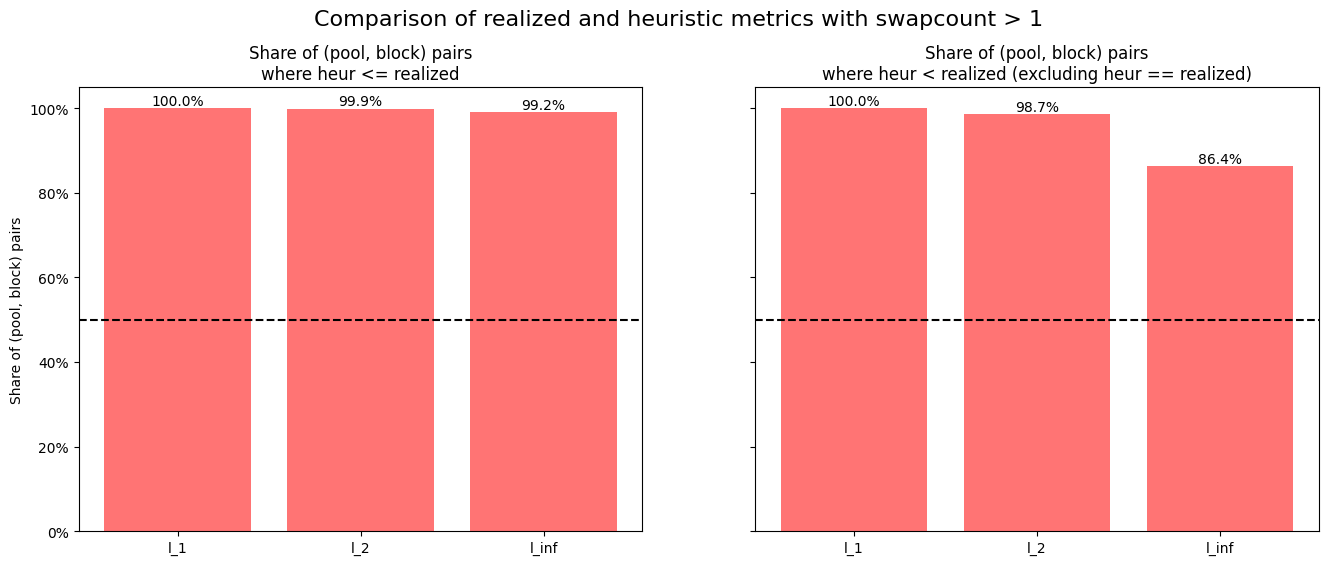

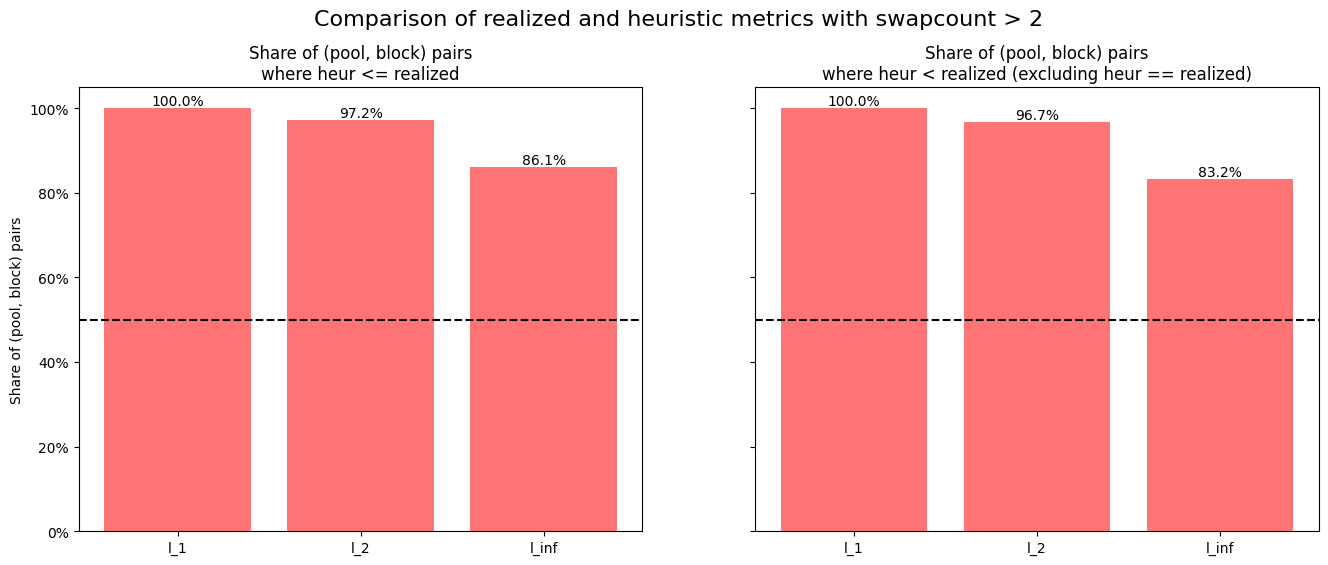

In [18]:
def plot_metric_comparison(df, ax1, ax2):
    differences = df[realized_metrics].values - df[volume_metrics].values

    diff_df = pd.DataFrame(differences, columns=["l_1", "l_2", "l_inf"])
    diff_df_no_zeros = diff_df[(diff_df != 0).all(1)]

    # Plot the rate each metric is positive
    bars = ax1.bar(x=diff_df.columns, height=(diff_df >= 0).mean(), color=bar_cols[1])

    ax1.set_title("Share of (pool, block) pairs\nwhere heur <= realized")
    ax1.set_ylabel("Share of (pool, block) pairs")
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

    # Add horizontal line at 50%
    ax1.axhline(0.5, color="black", linestyle="--")

    bars = ax2.bar(
        x=diff_df_no_zeros.columns,
        height=(diff_df_no_zeros >= 0).mean(),
        color=bar_cols[1],
    )

    ax2.set_title("Share of (pool, block) pairs\nwhere heur < realized (excluding heur == realized)")
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

    # Add horizontal line at 50%
    ax2.axhline(0.5, color="black", linestyle="--")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 1", fontsize=16)
plot_metric_comparison(df_metric, ax1, ax2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 2", fontsize=16)
plot_metric_comparison(df_metric_2, ax1, ax2)

### Heuristic $\widehat{T}^*$ vs. $T^*$

The below shows that in 85 % of cases where the realized order is worse than the optimal order, the heuristic is equal to the optimal order.


86.9% of (pool, block) pairs have heur == T*, mean heur / T* = 1.05
88.5% of (pool, block) pairs have heur == T*, mean heur / T* = 1.03
71.7% of (pool, block) pairs have heur == T*, mean heur / T* = 1.02


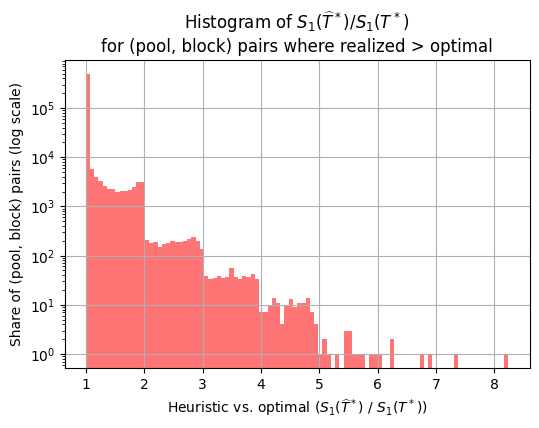

In [19]:
df1 = df_metric[(df_metric.tstar_l1 != 0) & (df_metric.realized_l1 != df_metric.tstar_l1)]

heur_rel = pd.DataFrame(df1[volume_metrics].values / df1[tstar_metrics].values, columns=["l_1", "l_2", "l_inf"])
heur_rel = heur_rel[heur_rel.l_1 < 1e1]

print(
    f"{(heur_rel.l_1 == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_1.mean():.2f}"
)
print(
    f"{(heur_rel.l_2 == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_2.mean():.2f}"
)
print(
    f"{(heur_rel.l_inf == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_inf.mean():.2f}"
)

fig, ax = plt.subplots(figsize=(6, 4))
heur_rel.l_1.hist(bins=100, log=True, figsize=(6, 4), color=bar_cols[1], grid=True, ax=ax)
ax.set_title("Histogram of $S_1(\widehat{T}^*) / S_1(T^*)$\nfor (pool, block) pairs where realized > optimal")
ax.set_xlabel("Heuristic vs. optimal ($S_1(\widehat{T}^*)$ / $S_1(T^*)$)")
ax.set_ylabel("Share of (pool, block) pairs (log scale)")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / "histogram.pdf"))

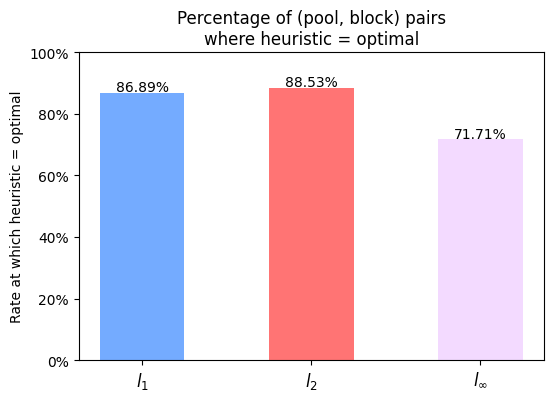

In [20]:
# Metrics
metrics = ["l_1", "l_2", "l_\infty"]

# Percentage of (pool, block) pairs where heur == T*
percentages = [
    (heur_rel.l_1 == 1).mean(),
    (heur_rel.l_2 == 1).mean(),
    (heur_rel.l_inf == 1).mean(),
]


fig, ax = plt.subplots(figsize=(6, 4))

# Bar width
width = 0.5
x = np.arange(len(metrics))  # Use the number of metrics as x-values

# Plot the percentages (first group)
for i, (percentage, metric, col) in enumerate(zip(percentages, metrics, bar_cols)):
    bar = ax.bar(x[i], percentage, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.005, f"{percentage:.2%}", ha="center")

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_ylim(0, 1)
# ax.legend(frameon=False, ncol=3, fontsize=12)
ax.set_ylabel("Rate at which heuristic = optimal")

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([f"${metric}$" for metric in metrics], fontsize=12)

ax.set_title("Percentage of (pool, block) pairs\nwhere heuristic = optimal")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / "percent_optimal.pdf"))

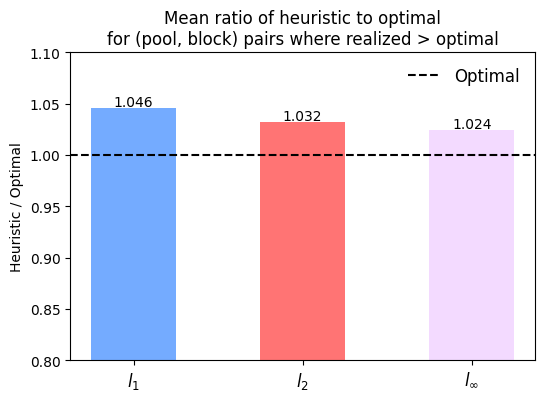

In [21]:
# Mean ratio heur / T*
mean_ratios = [heur_rel.l_1.mean(), heur_rel.l_2.mean(), heur_rel.l_inf.mean()]

fig, ax = plt.subplots(figsize=(6, 4))
# Plot the mean ratios (second group)
for i, (mean_ratio, metric, col) in enumerate(zip(mean_ratios, metrics, bar_cols)):
    bar = ax.bar(x[i], mean_ratio, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.002, f"{mean_ratio:.3f}", ha="center")

ax.set_ylim(0.8, 1.1)
ax.axhline(1, color="black", linestyle="--", xmin=0, xmax=1, label="Optimal")  # Add horizontal line at 1 (optimal)

# Add labels and title
# ax.set_title('Comparison of heuristic and optimal metrics')
ax.set_ylabel("Heuristic / Optimal")
# ax.set_xticks(x)
# ax.set_xticklabels(['Percentage', 'Mean Ratio'])
ax.legend(frameon=False, ncol=3, fontsize=12)

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([f"${metric}$" for metric in metrics], fontsize=12)

ax.set_title("Mean ratio of heuristic to optimal\nfor (pool, block) pairs where realized > optimal")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / "mean_ratio.pdf"))

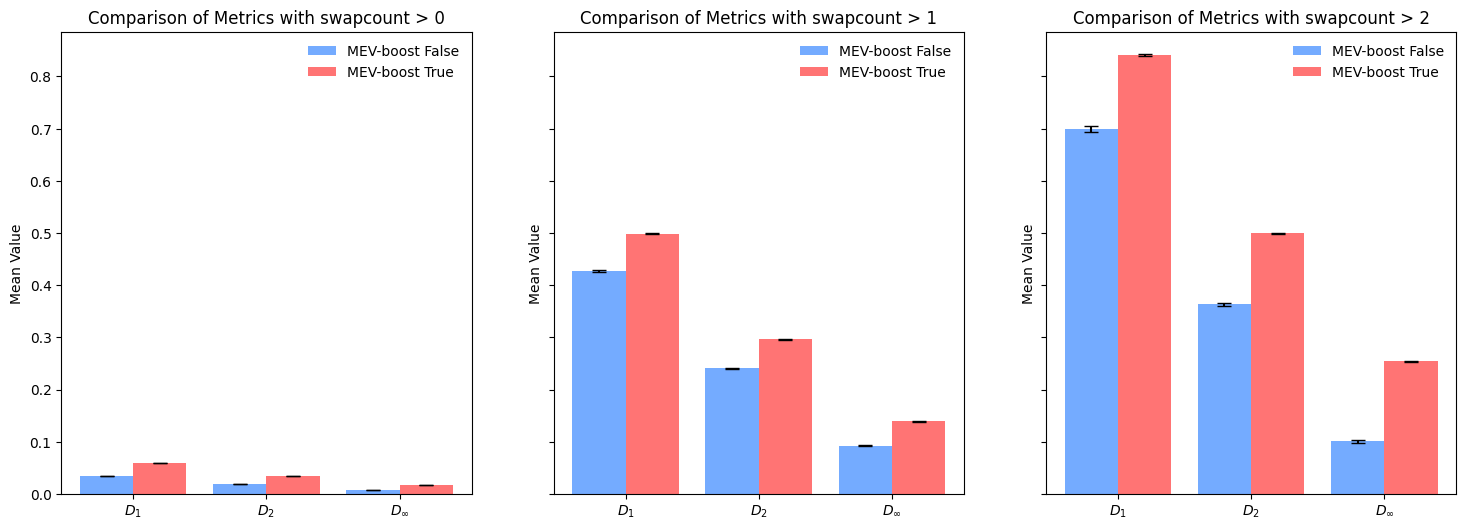

In [22]:
metrics = ["metric_l1", "metric_l2", "metric_linf"]
metrics_latex = ["$D_1$", "$D_2$", "$D_\\infty$"]


def plot_between_group_comp(df, ax, title=None):
    # Split the DataFrame into two groups based on MEV-boost (true/false)
    grouped = df.groupby("mev_boost")

    # Define the metrics

    # Store means and standard errors for both groups
    means = []
    errors = []

    # Calculate the means and standard error for each metric
    for metric in metrics:
        mean = grouped[metric].mean()
        error = grouped[metric].sem()
        means.append(mean)
        errors.append(error)

    # Convert to a NumPy array for easy indexing
    means = np.array(means)
    errors = np.array(errors)

    # Plot the means with error bars
    width = 0.4  # Width of the bars
    x = np.arange(len(metrics))

    for i, label in enumerate(["MEV-boost False", "MEV-boost True"]):
        ax.bar(x + i * width, means[:, i], width=width, yerr=errors[:, i], capsize=5, label=label, color=bar_cols[i])

    ax.set_ylabel("Mean Value")
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics_latex)
    ax.legend(frameon=False)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_between_group_comp(df_metric, ax1, title="Comparison of Metrics with swapcount > 0")
plot_between_group_comp(df_metric_1, ax2, title="Comparison of Metrics with swapcount > 1")
plot_between_group_comp(df_metric_2, ax3, title="Comparison of Metrics with swapcount > 2")

In [23]:
df_metric_2.shape

(205071, 25)

In [24]:
df_metric_agg = df_metric.groupby("block_number").agg(
    {
        "metric_l1": "mean",
        "metric_l2": "mean",
        "metric_linf": "mean",
        "mev_boost": "first",
    }
)

df_metric_agg_1 = df_metric_1.groupby("block_number").agg(
    {
        "metric_l1": "mean",
        "metric_l2": "mean",
        "metric_linf": "mean",
        "mev_boost": "first",
    }
)

df_metric_agg_2 = df_metric_2.groupby("block_number").agg(
    {
        "metric_l1": "mean",
        "metric_l2": "mean",
        "metric_linf": "mean",
        "mev_boost": "first",
    }
)

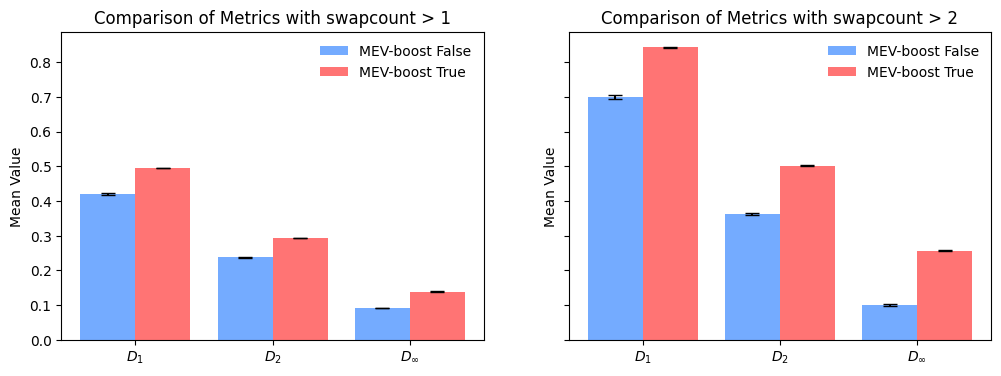

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_between_group_comp(df_metric_agg_1, ax1, title="Comparison of Metrics with swapcount > 1")
plot_between_group_comp(df_metric_agg_2, ax2, title="Comparison of Metrics with swapcount > 2")

## Application of the Metric

### Between-group comparison


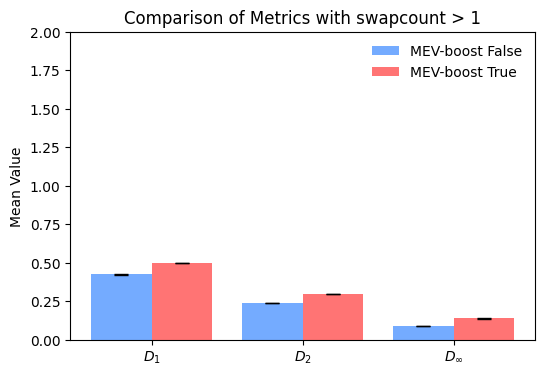

In [26]:
# Plotting for the paper
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim(0, 2)
plot_between_group_comp(df_metric_1, ax, title="Comparison of Metrics with swapcount > 1")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "empirical" / "mev_boost_vs_vanilla>1.pdf"))

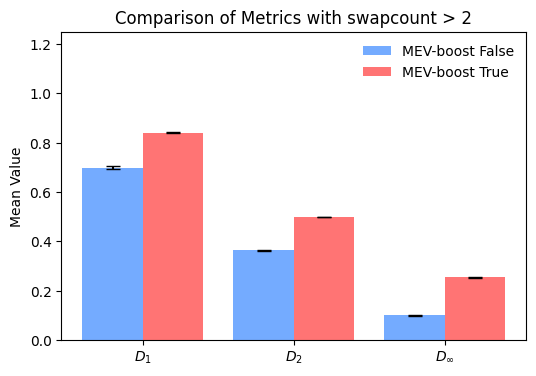

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim(0, 1.25)
plot_between_group_comp(df_metric_2, ax, title="Comparison of Metrics with swapcount > 2")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "empirical" / "mev_boost_vs_vanilla>2.pdf"))

## Plot some example price trajectories


Pool: 0x11950d141ecb863f01007add7d1a342041227b58, Block: 17165051, Swapcount: 5
Pool: 0x4b9d0663acb7a774c327b679d423993c2a11a263, Block: 17133754, Swapcount: 4
Pool: 0x35579547a68bb72cc215ca47c9c5a7d6daa31050, Block: 17332512, Swapcount: 10
Pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640, Block: 17424191, Swapcount: 4
Pool: 0x9cd0d20ca1db098d85b553a19d8816104f9878bf, Block: 17322354, Swapcount: 4


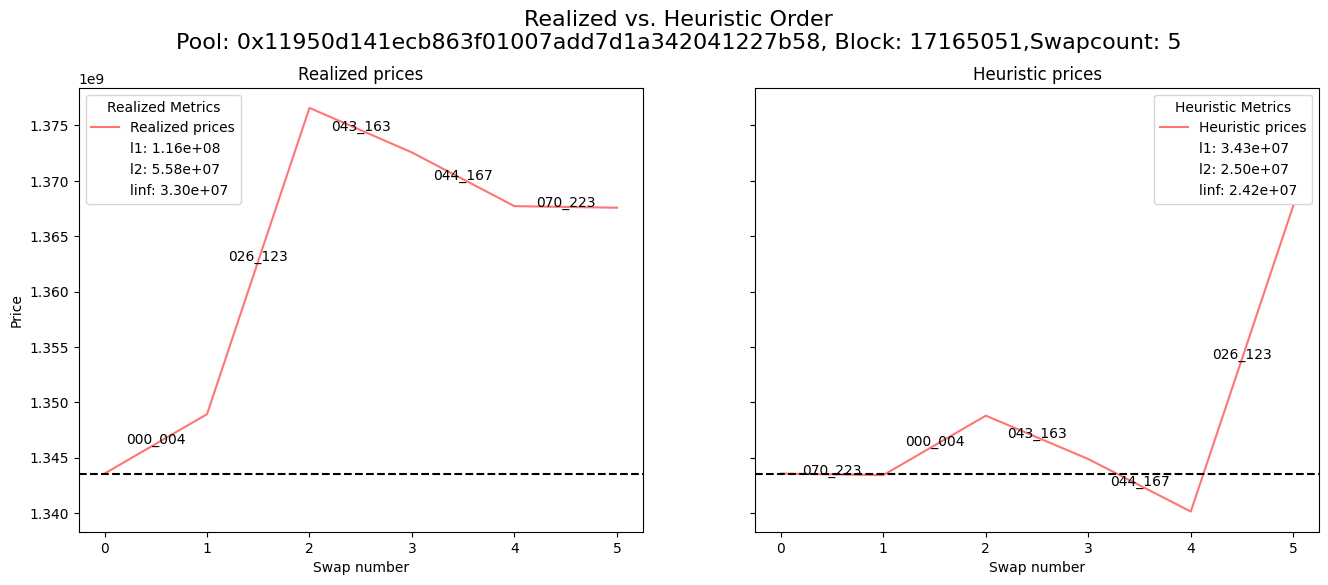

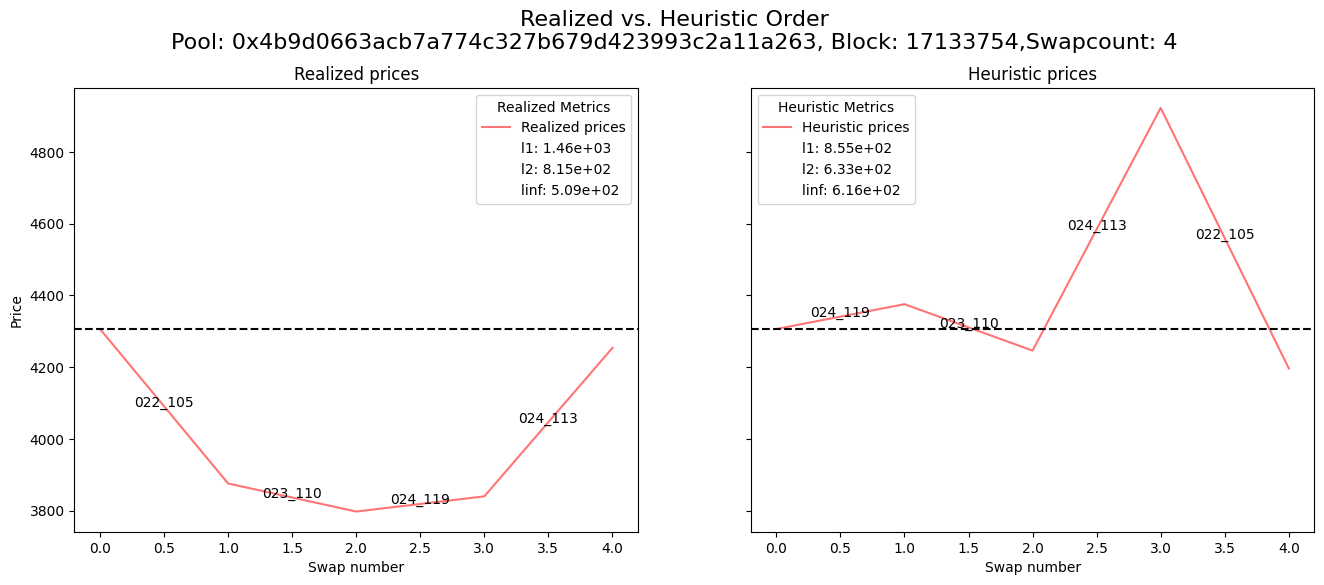

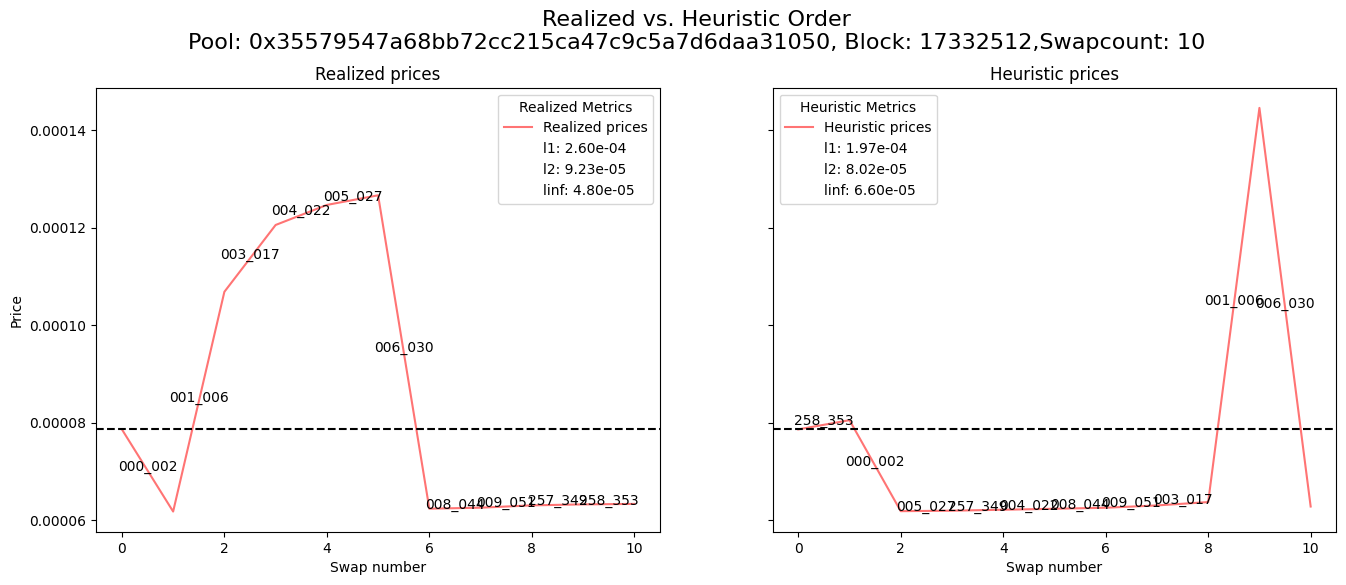

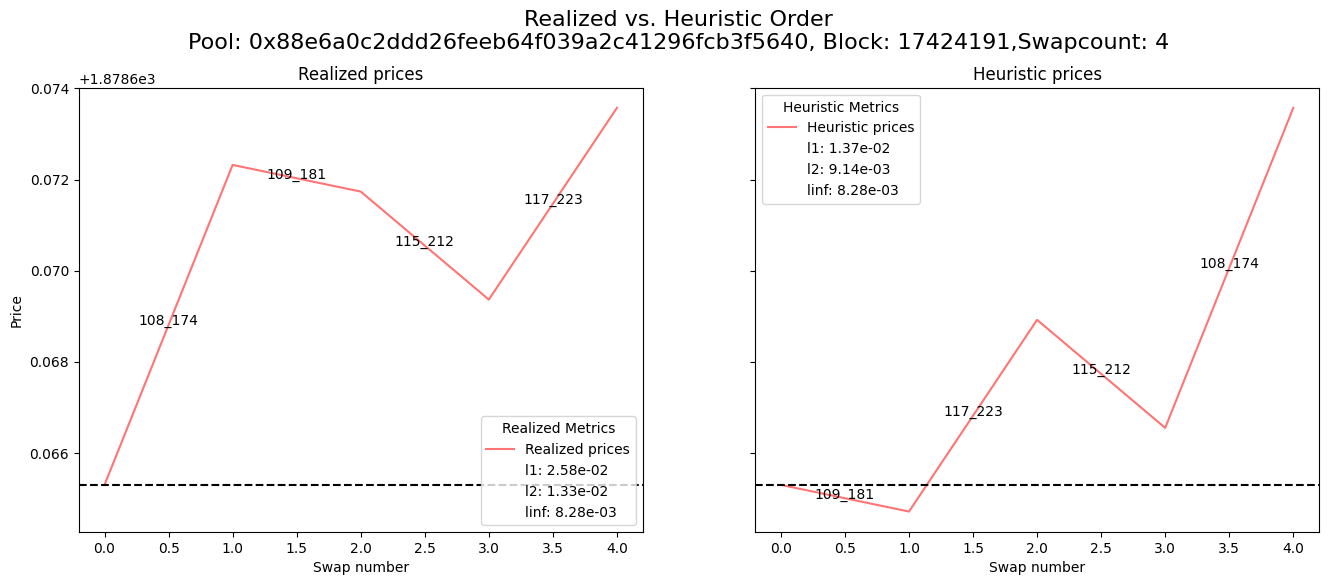

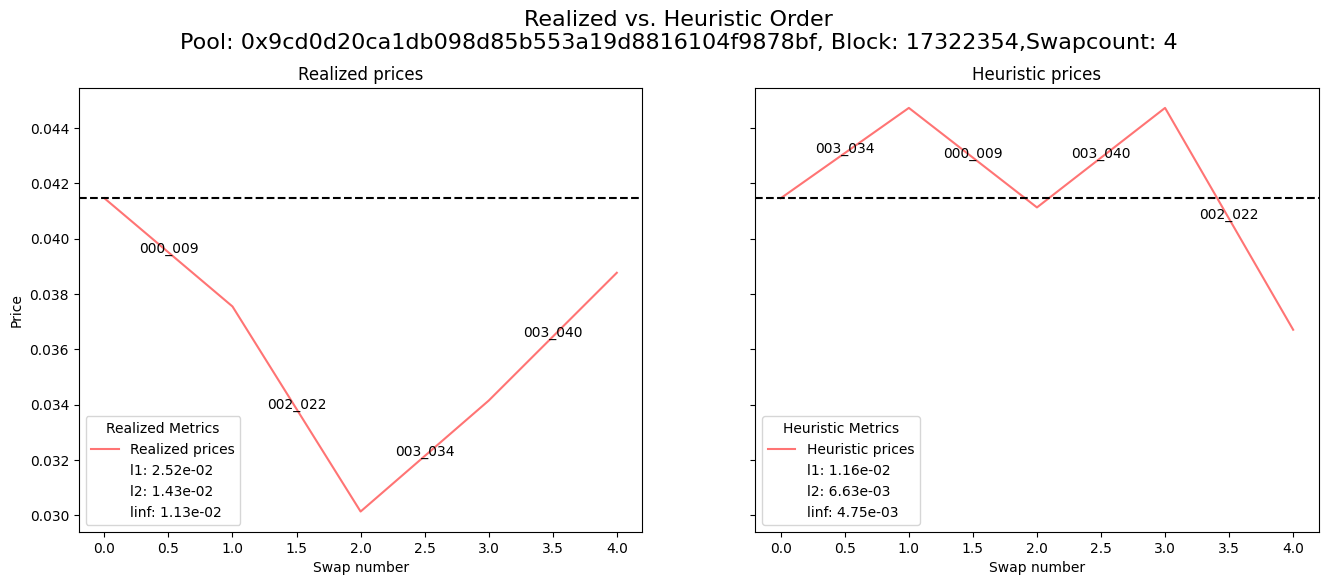

In [28]:
bar_col = bar_cols[1]

for i, row in df_metric[(df_metric.n_buys > 1) & (df_metric.n_sells > 1)].sample(n=5).iterrows():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    realized_prices = [row.baseline_price] + row.realized_prices
    heuristic_prices = [row.baseline_price] + row.volume_heur_prices
    ax1.plot(realized_prices, label="Realized prices", color=bar_col)
    ax2.plot(heuristic_prices, label="Heuristic prices", color=bar_col)

    # Add baseline price
    ax1.axhline(row.baseline_price, color="black", linestyle="--", label="Baseline price")
    ax2.axhline(row.baseline_price, color="black", linestyle="--", label="Baseline price")

    ax1.set_title("Realized prices")
    ax2.set_title("Heuristic prices")

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Swap number")
    ax2.set_xlabel("Swap number")

    # Create custom legend for ax1 (Realized Metrics)
    realized_legend_elements = [
        Line2D([0], [0], label="Realized prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.realized_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.realized_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.realized_linf:.2e}"),
    ]
    ax1.legend(handles=realized_legend_elements, title="Realized Metrics")

    # Create custom legend for ax2 (Heuristic Metrics)
    heuristic_legend_elements = [
        Line2D([0], [0], label="Heuristic prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.volume_heur_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.volume_heur_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.volume_heur_linf:.2e}"),
    ]
    ax2.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

    # Add swap labels for realized prices
    swap_labels = row.realized_order
    for j in range(len(swap_labels)):
        ax1.text(j + 0.5, (realized_prices[j] + realized_prices[j + 1]) / 2, swap_labels[j], ha="center")

    # Add swap labels for heuristic prices
    swap_labels = row.volume_heur_order
    for j in range(len(swap_labels)):
        ax2.text(j + 0.5, (heuristic_prices[j] + heuristic_prices[j + 1]) / 2, swap_labels[j], ha="center")

    fig.subplots_adjust(top=0.85)
    fig.suptitle(
        f"Realized vs. Heuristic Order\nPool: {row.pool_address}, Block: {row.block_number},Swapcount: {row.num_transactions}",
        fontsize=16,
    )
    print(f"Pool: {row.pool_address}, Block: {row.block_number}, Swapcount: {row.num_transactions}")

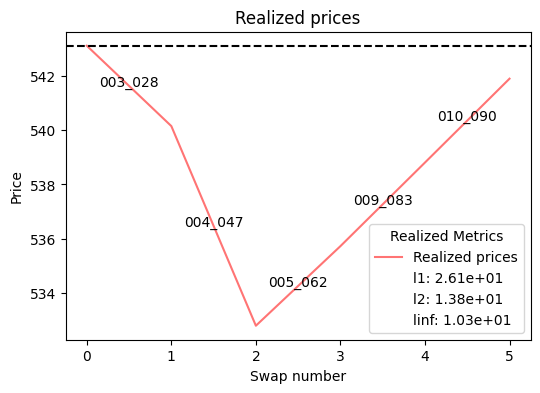

In [29]:
# Create separate plots for:
# Pool: 0x4c1c69be20fadee2f3e7883f1c618be2df828e9c, Block: 17275081,Swapcount: 5
# Pool: 0xd8de6af55f618a7bc69835d55ddc6582220c36c0, Block: 16528093, Swapcount: 5


swap = df_metric[
    (df_metric.pool_address == "0xd8de6af55f618a7bc69835d55ddc6582220c36c0") & (df_metric.block_number == 16528093)
].iloc[0]
fig, ax = plt.subplots(figsize=(6, 4))

realized_prices = [swap.baseline_price] + swap.realized_prices
ax.plot(realized_prices, label="Realized prices", color=bar_col)

# Add baseline price
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Realized prices")

ax.set_ylabel("Price")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Realized Metrics)
realized_legend_elements = [
    Line2D([0], [0], label="Realized prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.realized_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.realized_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.realized_linf:.2e}"),
]
ax.legend(handles=realized_legend_elements, title="Realized Metrics")


# Add swap labels for realized prices
swap_labels = swap.realized_order
for j in range(len(swap_labels)):
    ax.text(j + 0.5, (realized_prices[j] + realized_prices[j + 1]) / 2, swap_labels[j], ha="center")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / "realized_order.pdf"))

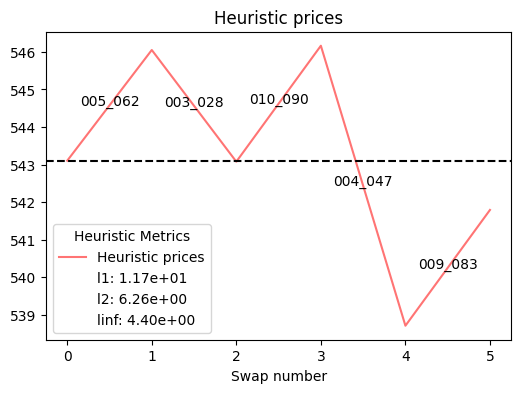

In [30]:
fig, ax = plt.subplots(figsize=(6, 4))

heuristic_prices = [swap.baseline_price] + swap.volume_heur_prices

ax.plot(heuristic_prices, label="Heuristic prices", color=bar_col)
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Heuristic prices")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Heuristic Metrics)
heuristic_legend_elements = [
    Line2D([0], [0], label="Heuristic prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.volume_heur_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.volume_heur_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.volume_heur_linf:.2e}"),
]
ax.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

# Add swap labels for heuristic prices
swap_labels = swap.volume_heur_order
for j in range(len(swap_labels)):
    ax.text(j + 0.5, (heuristic_prices[j] + heuristic_prices[j + 1]) / 2, swap_labels[j], ha="center")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / "heuristic_order.pdf"))

## How many samples are needed to get a good estimate of the metric?

In [31]:
def plot_with_error(ax, n_samples, means, errors, color, label):
    ax.plot(n_samples, means, color=color, label=label)
    ax.fill_between(n_samples, means - errors, means + errors, alpha=0.2, color=color)


def plot_comparison(ax, n_samples, vanilla_means, vanilla_errors, mev_means, mev_errors, z):
    std_err_str = f"$\\pm {z} \\times \\sigma_{{\\mu}}$"
    plot_with_error(ax, n_samples, vanilla_means, vanilla_errors * z, bar_cols[0], f"Vanilla {std_err_str}")
    plot_with_error(ax, n_samples, mev_means, mev_errors * z, bar_cols[1], f"MEV-boost {std_err_str}")

    ax.set_xlabel("Number of blocks observed")
    ax.set_ylabel("Mean $l_{\\infty}$ metric")
    ax.set_title("Mean $l_{\\infty}$ metric for different number of blocks observed")
    ax.legend(frameon=False)

In [32]:
metric = "metric_linf"

n_samples = list(range(2, 400))
grouped_data = [
    df_metric_agg_2.groupby("mev_boost").sample(n=i // 2, replace=True, random_state=69)
    for i in tqdm(n_samples, desc="Sampling")
]

print("Calculate the means and errors for vanilla")
vanilla_means, vanilla_errors = zip(
    *[(g.groupby("mev_boost")[metric].mean()[False], g.groupby("mev_boost")[metric].sem()[False]) for g in grouped_data]
)

print("Calculate the means and errors for MEV-boost")
mev_means, mev_errors = zip(
    *[(g.groupby("mev_boost")[metric].mean()[True], g.groupby("mev_boost")[metric].sem()[True]) for g in grouped_data]
)

vanilla_means, vanilla_errors = np.array(vanilla_means), np.array(vanilla_errors)
mev_means, mev_errors = np.array(mev_means), np.array(mev_errors)

Sampling:   0%|          | 0/398 [00:00<?, ?it/s]

Sampling: 100%|██████████| 398/398 [00:04<00:00, 87.62it/s]


Calculate the means and errors for vanilla
Calculate the means and errors for MEV-boost


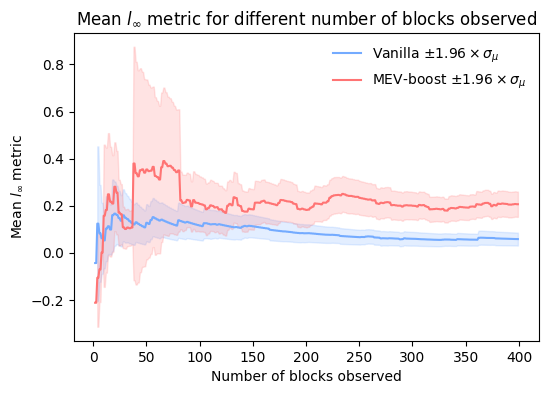

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_comparison(ax, n_samples, vanilla_means, vanilla_errors, mev_means, mev_errors, 1.96)

In [34]:
def single_run(run, df, metric, n_samples):
    grouped_data = [df.groupby("mev_boost").sample(n=i // 2, replace=True, random_state=69 + run) for i in n_samples]

    vanilla_means, vanilla_errors = zip(
        *[
            (g.groupby("mev_boost")[metric].mean()[False], g.groupby("mev_boost")[metric].sem()[False])
            for g in grouped_data
        ]
    )
    mev_means, mev_errors = zip(
        *[
            (g.groupby("mev_boost")[metric].mean()[True], g.groupby("mev_boost")[metric].sem()[True])
            for g in grouped_data
        ]
    )
    return vanilla_means, vanilla_errors, mev_means, mev_errors


def run_experiment(df, metric, max_samples, n_runs=50):
    n_samples = list(range(2, max_samples))

    all_vanilla_means = np.zeros((n_runs, len(n_samples)))
    all_vanilla_errors = np.zeros((n_runs, len(n_samples)))
    all_mev_means = np.zeros((n_runs, len(n_samples)))
    all_mev_errors = np.zeros((n_runs, len(n_samples)))

    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(single_run, range(n_runs), [df] * n_runs, [metric] * n_runs, [n_samples] * n_runs),
                total=n_runs,
            )
        )

    for i, (vanilla_means, vanilla_errors, mev_means, mev_errors) in enumerate(results):
        all_vanilla_means[i, :] = vanilla_means
        all_vanilla_errors[i, :] = vanilla_errors
        all_mev_means[i, :] = mev_means
        all_mev_errors[i, :] = mev_errors

    avg_vanilla_means = np.mean(all_vanilla_means, axis=0)
    avg_vanilla_errors = np.mean(all_vanilla_errors, axis=0)
    avg_mev_means = np.mean(all_mev_means, axis=0)
    avg_mev_errors = np.mean(all_mev_errors, axis=0)

    return avg_vanilla_means, avg_vanilla_errors, avg_mev_means, avg_mev_errors


avg_vanilla_means, avg_vanilla_errors, avg_mev_means, avg_mev_errors = run_experiment(df_metric_agg_2, metric, 400, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:08<00:00,  4.98s/it]


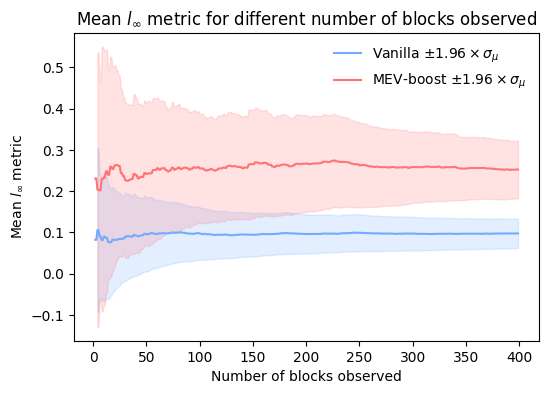

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_comparison(ax, n_samples, avg_vanilla_means, avg_vanilla_errors, avg_mev_means, avg_mev_errors, z=1.96)

## Can we meaningfully distinguish different builders and relays?

In [87]:
# Get a mapping from block number to builder
block_builders = pd.read_sql_query(
    """
    SELECT block_number, builder, relay
    FROM mev_boost
    """,
    postgres_uri,
)

block_builders.head()

,block_number,builder,relay
0,15537940,Flashbots,flashbots
1,15537948,Flashbots,flashbots
2,15537978,Flashbots,flashbots
3,15538064,Flashbots,flashbots
4,15538094,Flashbots,flashbots


In [102]:
# Augment the df_metric_agg_2 DataFrame with the builder
metric_2_builder_relay = df_metric_agg_2.merge(block_builders, on="block_number", how="left")
metric_2_builder_relay.builder = metric_2_builder_relay.builder.fillna("Vanilla")
metric_2_builder_relay.relay = metric_2_builder_relay.relay.fillna("Vanilla")

metric_2_builder_relay.head()

,block_number,metric_l1,metric_l2,metric_linf,mev_boost,builder,relay
0,15537940,0.992384,0.414282,0.000125,True,Flashbots,flashbots
1,15537941,1.597674,0.697425,0.000114,False,Vanilla,Vanilla
2,15537943,0.845245,0.416044,0.016878,False,Vanilla,Vanilla
3,15537946,0.564188,0.281651,0.008746,False,Vanilla,Vanilla
4,15537948,0.784107,0.313921,0.096330,True,Flashbots,flashbots


### Let's start by looking at builders

In [103]:
# from scipy.stats import sem
# import numpy as np

# metric_2_builders_agg = metric_2_builders.groupby(["builder"]).agg(
#     {
#         "metric_l1": ["mean", lambda x: sem(x, ddof=1) if len(x) > 1 else np.nan],
#         "metric_l2": ["mean", lambda x: sem(x, ddof=1) if len(x) > 1 else np.nan],
#         "metric_linf": ["mean", lambda x: sem(x, ddof=1) if len(x) > 1 else np.nan],
#         "mev_boost": "first",
#         "block_number": "count",
#     }
# )

# Aggregate the data by builder type
name_mapping = {
    "Gambit Labs (https://gmbit.co)": "gmbit.co",
    "BuildAI (https://buildai.net)": "buildai.net",
    "https://edennetwork.io": "edennetwork.io",
    "viva ultrasound&agnostic by 0x69": "Viva Ultrasound",
    "0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c": "0x83bee51799",
    "https://eth-builder.com": "eth-builder.com",
}
metric_2_builder_relay.builder = metric_2_builder_relay.builder.replace(name_mapping)

metric_2_builder_relay.head()

,block_number,metric_l1,metric_l2,metric_linf,mev_boost,builder,relay
0,15537940,0.992384,0.414282,0.000125,True,Flashbots,flashbots
1,15537941,1.597674,0.697425,0.000114,False,Vanilla,Vanilla
2,15537943,0.845245,0.416044,0.016878,False,Vanilla,Vanilla
3,15537946,0.564188,0.281651,0.008746,False,Vanilla,Vanilla
4,15537948,0.784107,0.313921,0.096330,True,Flashbots,flashbots


In [90]:
def get_aggregated_metrics(df, groupby, sort_by, n_samples=30):
    df_agg = df.groupby([groupby]).agg(
        {
            "metric_l1": "mean",
            "metric_l2": "mean",
            "metric_linf": "mean",
            "mev_boost": "first",
            "block_number": "count",
        }
    )

    df_agg = df_agg.sort_values(by=sort_by, ascending=False).reset_index()
    df_agg = df_agg[df_agg.block_number >= n_samples]

    return df_agg

In [91]:
metric_2_builders_agg = get_aggregated_metrics(metric_2_builder_relay, "builder", "metric_linf", n_samples=30)

metric_2_builders_agg

,builder,metric_l1,metric_l2,metric_linf,mev_boost,block_number
0,mars,0.911890,0.688080,0.600560,True,90
2,Bob the builder,0.963622,0.701569,0.520800,True,1022
4,buildai.net,0.913917,0.638949,0.448749,True,2348
5,edennetwork.io,0.956270,0.604899,0.373411,True,2059
6,boba-builder.com,0.754621,0.512491,0.359837,True,624
9,lightspeedbuilder.info,0.782384,0.485228,0.286760,True,228
10,builder0x69,0.831771,0.511570,0.277595,True,54408
11,Flashbots SGX,0.808788,0.468468,0.270197,True,123
12,Flashbots,0.850219,0.501147,0.255179,True,45434
13,beaverbuild.org,0.851717,0.501823,0.254121,True,46198


In [92]:
melted = metric_2_builders_agg.melt(
    id_vars=["builder", "mev_boost", "block_number"], value_vars=["metric_l1", "metric_l2", "metric_linf"]
)

melted.head(n=10)

,builder,mev_boost,block_number,variable,value
0,mars,True,90,metric_l1,0.911890
1,Bob the builder,True,1022,metric_l1,0.963622
2,buildai.net,True,2348,metric_l1,0.913917
3,edennetwork.io,True,2059,metric_l1,0.956270
4,boba-builder.com,True,624,metric_l1,0.754621
5,lightspeedbuilder.info,True,228,metric_l1,0.782384
6,builder0x69,True,54408,metric_l1,0.831771
7,Flashbots SGX,True,123,metric_l1,0.808788
8,Flashbots,True,45434,metric_l1,0.850219
9,beaverbuild.org,True,46198,metric_l1,0.851717


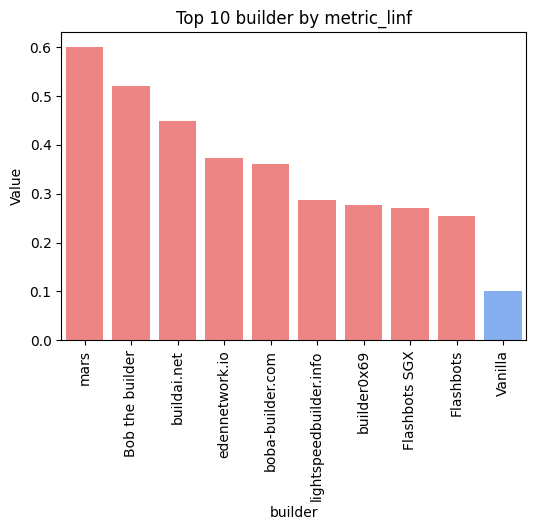

In [93]:
def plot_top_group(ax, df, group, metric, n, bar_cols):
    # Filter and sort the DataFrame
    df_filtered = df[df["variable"] == metric]
    df_filtered = df_filtered.sort_values(by="value", ascending=False)

    # Separate 'Vanilla' and other builders
    df_vanilla = df_filtered[df_filtered[group] == "Vanilla"]
    df_others = df_filtered[df_filtered[group] != "Vanilla"].head(n - 1)

    # Combine and sort so 'Vanilla' is always first
    df_final = pd.concat([df_vanilla, df_others]).sort_values(by="value", ascending=False)

    # Custom color palette
    custom_palette = [bar_cols[0] if grouping == "Vanilla" else bar_cols[1] for grouping in df_final[group]]

    # Plotting
    sns.barplot(x=group, y="value", data=df_final, palette=custom_palette, ax=ax)
    ax.set_title(f"Top {n} {group} by {metric}")
    ax.set_ylabel("Value")
    ax.set_xlabel(group)

    # Rotate x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


fig, ax = plt.subplots(figsize=(6, 4))
plot_top_group(ax, melted, "builder", "metric_linf", 10, bar_cols)

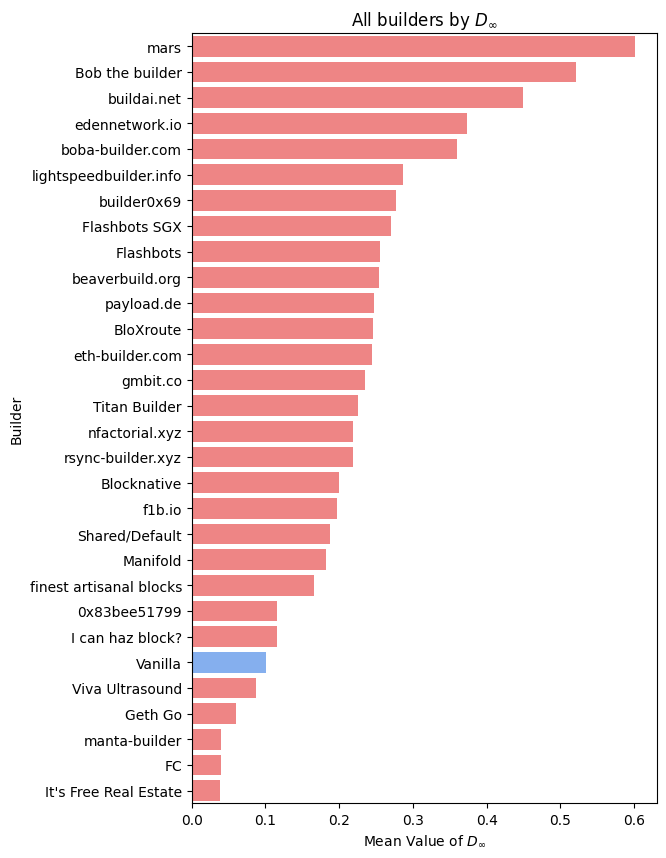

In [98]:
def plot_all_builders_appendix(df, metric, aggregate_over):
    # Filter and sort the DataFrame
    df_filtered = df[df["variable"] == metric]
    df_filtered = df_filtered.sort_values(by="value", ascending=False)

    # Custom color palette
    custom_palette = [bar_cols[0] if builder == "Vanilla" else bar_cols[1] for builder in df_filtered[aggregate_over]]
    metric_latex = metrics_latex[metrics.index(metric)]

    # Plotting
    plt.figure(figsize=(6, 10))
    sns.barplot(y=aggregate_over, x="value", data=df_filtered, palette=custom_palette)
    plt.title(f"All {aggregate_over}s by {metric_latex}")
    plt.xlabel(f"Mean Value of {metric_latex}")
    plt.ylabel(aggregate_over.capitalize())


plot_all_builders_appendix(melted, "metric_linf", "builder")

### So what about relays?

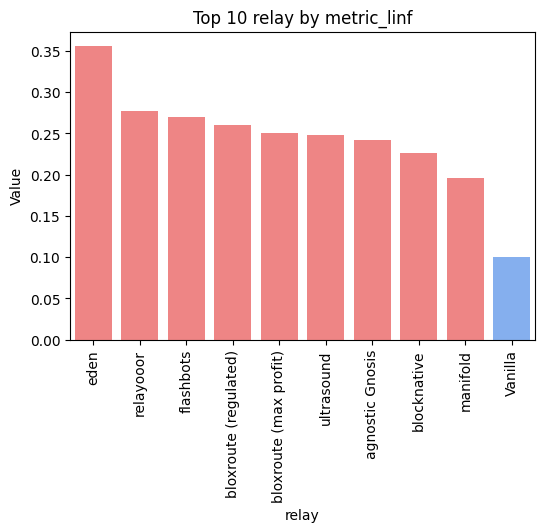

In [99]:
metric_2_relay_agg = get_aggregated_metrics(metric_2_builder_relay, "relay", "metric_linf", n_samples=30)

melted_relay = metric_2_relay_agg.melt(
    id_vars=["relay", "mev_boost", "block_number"], value_vars=["metric_l1", "metric_l2", "metric_linf"]
)

fig, ax = plt.subplots(figsize=(6, 4))
plot_top_group(ax, melted_relay, "relay", "metric_linf", 10, bar_cols)

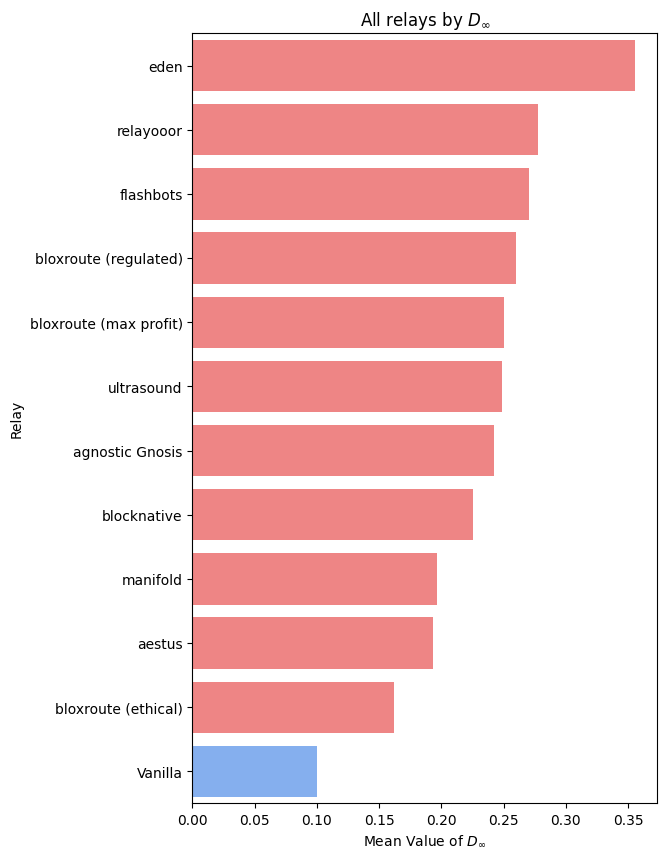

In [100]:
plot_all_builders_appendix(melted_relay, "metric_linf", "relay")

## Does it make sense to look at market share for builders and relays?

In [119]:
metric_2_builder_relay.rolling(1000).groupby("builder").agg(
    {
        "block_number": "count",
    }
)

AttributeError: 'Rolling' object has no attribute 'groupby'